In [1]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeVigoV2
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
import json

sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "pauli_lindblad_per"))

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

In [2]:
backend = FakeVigoV2()

In [3]:
qc = QuantumCircuit(5)
qc.cx(3,4)
new_qc = transpile(qc,backend)
circuits = [new_qc]
new_qc.draw()

q_0 -> 0 ─────
              
q_1 -> 1 ─────
              
q_2 -> 2 ─────
              
q_3 -> 3 ──■──
         ┌─┴─┐
q_4 -> 4 ┤ X ├
         └───┘

In [4]:
def executor(circuits):
    return backend.run(circuits).result().get_counts()

In [5]:
experiment = tomography(circuits = circuits, inst_map = [0,1,2,3,4], backend = backend, tomography_connections=True, sum_over_lambda=True)

In [6]:
experiment.generate(samples = 1, single_samples = 1, depths = [2,4,8,16])

In [7]:
experiment.run(executor)

In [8]:
noisedataframe = experiment.analyze()

In [9]:
perexp = experiment.create_per_experiment(circuits)

In [10]:
noise_strengths = [0,0.5,1,2]
expectations = ["ZIIII","IZIII"]
perexp.generate(expectations = expectations, samples = 10, noise_strengths = noise_strengths)

## PER

In [11]:
perexp.run(executor)

In [12]:
circuit_results = perexp.analyze()

In [13]:
results = []
results_errors = []
results_at_noise = []
results_at_noise_errors = []
for run in circuit_results:
    tot = 0
    tot_error = [0,0]
    tot_at_noise = [0 for _ in range(len(noise_strengths))]
    tot_at_noise_errors = [0 for _ in range(len(noise_strengths))]
    for op in expectations:
        #get the full per results
        expec = run.get_result(op).expectation
        tot += expec

        #get the corresponding fit-errors
        expec_error = run.get_result(op).expectation_error
        for i in range(0,len(tot_error)):
            tot_error[i] += expec_error[i]/len(expectations)

        #get the value at the different noise levels
        expec_at_noise = run.get_result(op).get_expectations()
        for i in range(0,len(tot_at_noise)):
            tot_at_noise[i] += expec_at_noise[i]/len(expectations)

        expec_at_noise_error = [run.get_result(op).get_std_of_strengths(strength) for strength in noise_strengths]
        for i in range(0,len(tot_at_noise)):
            tot_at_noise_errors[i] += expec_at_noise_error[i]/len(expectations)

        

    results.append(tot/len(expectations))
    results_errors.append(tot_error)
    results_at_noise.append(tot_at_noise)
    results_at_noise_errors.append(tot_at_noise_errors)

savi = {}
savi["results"] = results
savi["results_errors"] = results_errors
savi["results_at_noise"] = results_at_noise
savi["results_at_noise_errors"] = results_at_noise_errors


In [14]:
circuit_results[-1]._per_circ.overhead(0)

1.032736984233862

In [15]:
noisyresult = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= backend.run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    noisyresult.append(tot/(1024*n*2))
savi["noisyresult"] = noisyresult

NameError: name 'n' is not defined

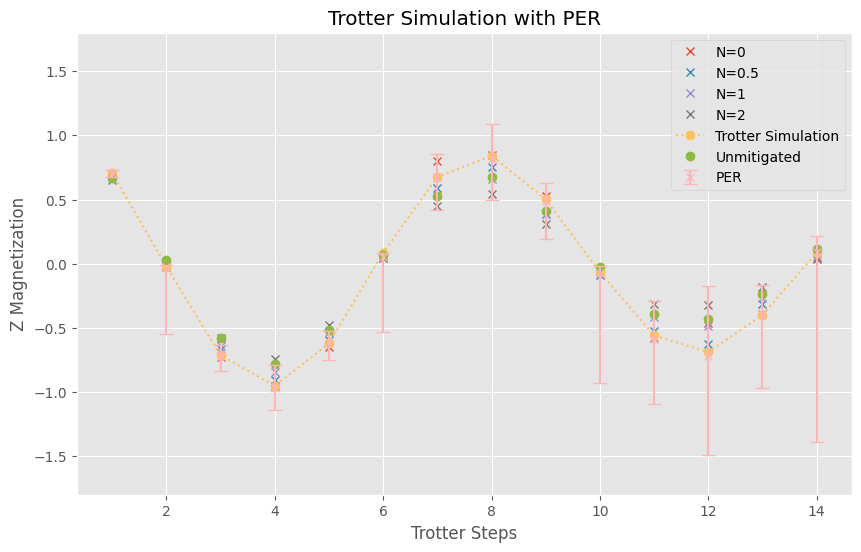

In [ ]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    res.append(tot/(1024*n*2))

savi["res"] = res
with open('arrays.json', 'w') as file:
    json.dump(arrays, file)

In [ ]:


plt.figure(figsize=(10,6))
for i, noise in enumerate(list(circuit_results)[0].get_result(expectations[0]).get_strengths()):
    plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.errorbar(range(1,15), results, yerr=[[np.abs(res[1]) for res in results_errors],[np.abs(res[0]) for res in results_errors]],fmt='x', capsize=5, label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
plt.savefig("Trotter_Sim_PER.png")

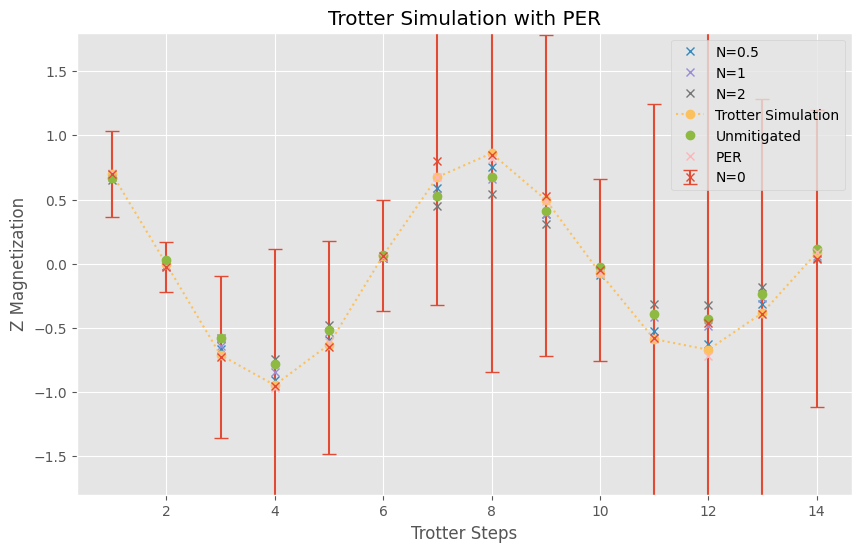

In [ ]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    res.append(tot/(1024*n*2))

plt.figure(figsize=(10,6))
for i, noise in enumerate(list(circuit_results)[0].get_result(expectations[0]).get_strengths()):
    if noise == 0:
        plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], capsize=5, label='N='+str(noise))
    else:
        plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
        
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.plot(range(1,15), results, 'x', label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
plt.savefig("Trotter_Sim_n_0.png")

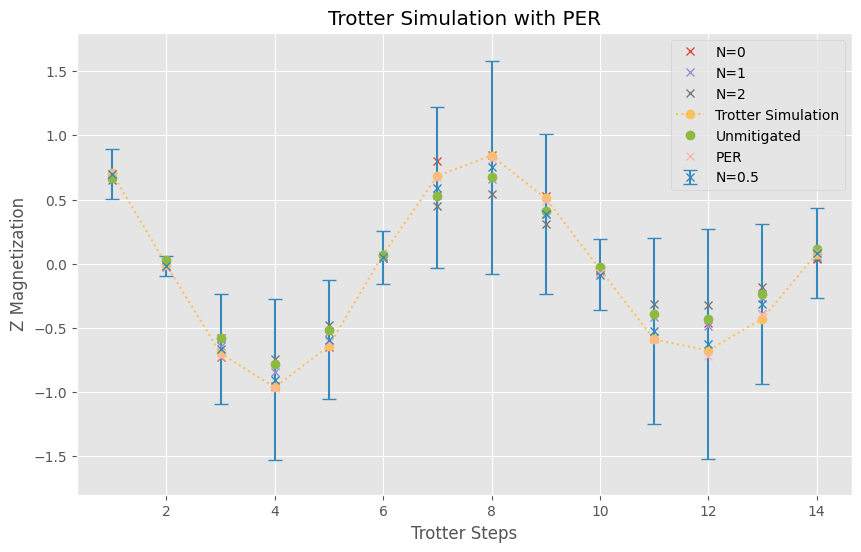

In [ ]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    res.append(tot/(1024*n*2))

plt.figure(figsize=(10,6))
for i, noise in enumerate(list(circuit_results)[0].get_result(expectations[0]).get_strengths()):
    if noise == 0.5:
        plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], label='N='+str(noise), capsize=5)
    else:
        plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
        
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.plot(range(1,15), results, 'x', label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
plt.savefig("Trotter_Sim_n_05.png")

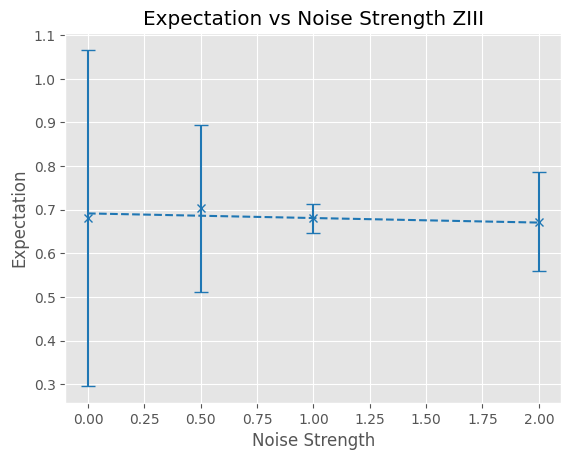

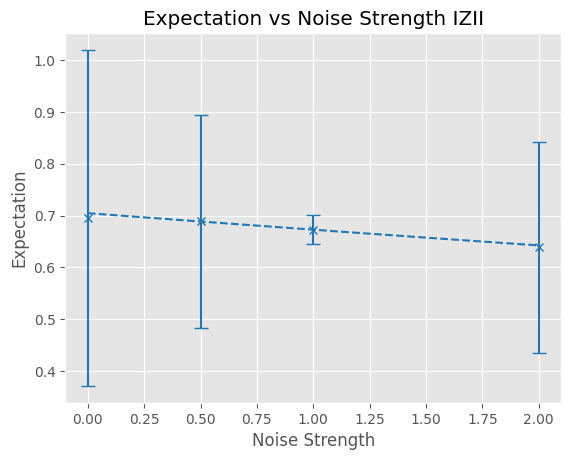

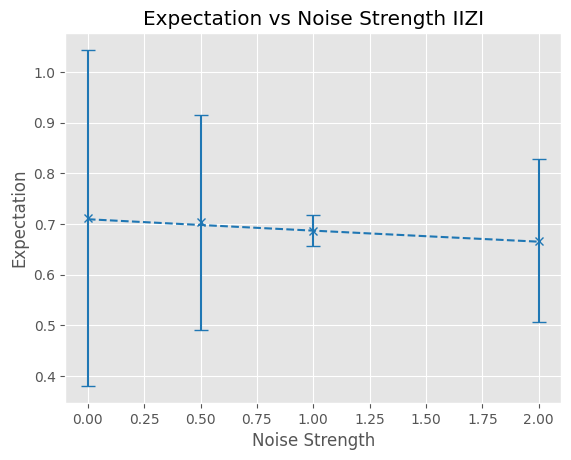

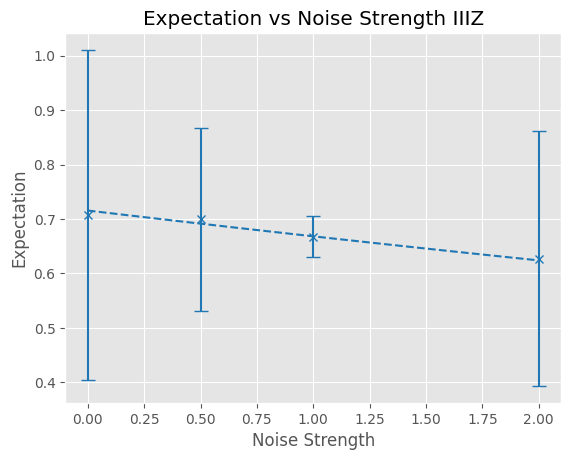

In [ ]:
ax = circuit_results[0].get_result("ZIIII").plot()
plt.title('Expectation vs Noise Strength ZIII')
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.savefig("Expectation_vs_Noise_Strength_ZIII.png")
circuit_results[0].get_result("IZIII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IZII')
plt.savefig("Expectation_vs_Noise_Strength_IZII.png")
circuit_results[0].get_result("IIZII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIZI')
plt.savefig("Expectation_vs_Noise_Strength_IIZI.png")
circuit_results[0].get_result("IIIZI").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIIZ')
plt.savefig("Expectation_vs_Noise_Strength_IIIZ.png")

## Analysis

In [ ]:
layer1 = experiment.analysis.get_layer_data(0)

<Axes: >

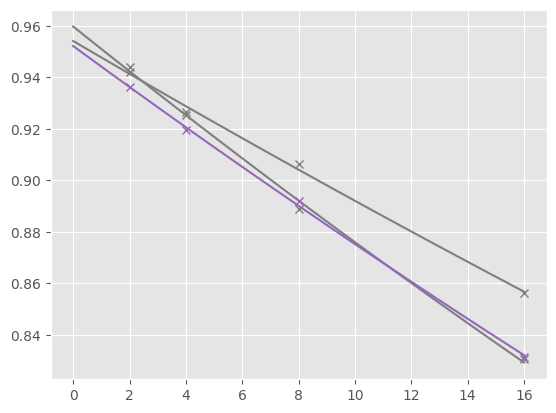

In [ ]:
layer1.graph((1,))

<Axes: >

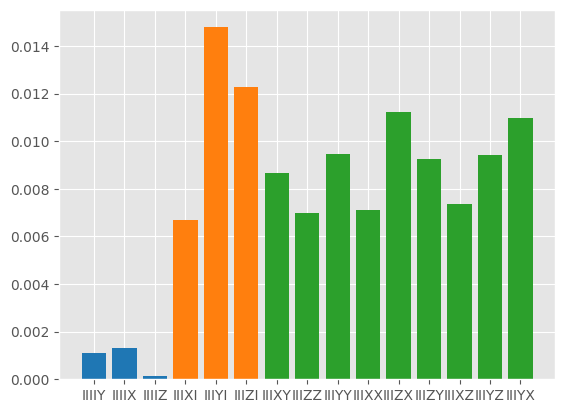

In [ ]:
layer1.plot_infidelitites((0,),(1,),(0,1))

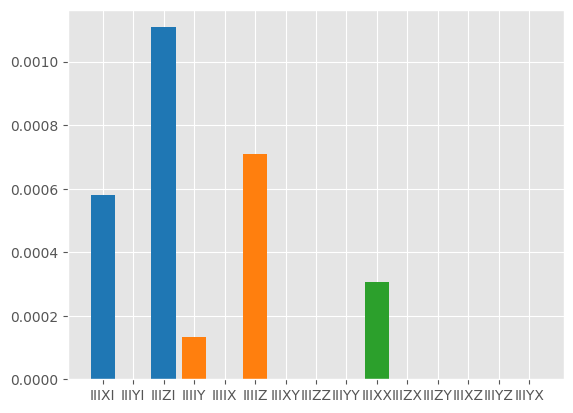

In [ ]:
layer1.plot_coeffs((1,),(0,),(0,1))

In [ ]:
import pickle
with open("graph.pickle", "wb") as f:
    pickle.dump(results, f)